<a href="https://colab.research.google.com/github/aisyahbelajar/Analisis-sentiment-film-merah-putih-one-for-all/blob/main/mix_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis Sentimen Komentar Youtube pada FIlm Merah Putih One For All




In [3]:
!pip install sastrawi
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.6 MB/s eta 0:00:00


## Get Data

In [4]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import io

for fn in uploaded.keys():
    df = pd.read_csv(io.BytesIO(uploaded[fn]), encoding='latin-1')
    display(df.head())

Saving youtube-comments-OfficialTrailerMERAHPUTIHONEFORALLCinépolisIndonesia.csv to youtube-comments-OfficialTrailerMERAHPUTIHONEFORALLCinépolisIndonesia.csv


,Date,Username,Comment,like
0,2025-09-11T09:53:46Z,@Malaysyetananjing,Gak serius bikin film ð malah yang ada biki...,0
1,2025-09-11T09:48:24Z,@RayNal-y5w,Lebih bagus ejen ali,0
2,2025-09-11T08:05:06Z,@Baceprot14,jir grafik majapahit aokwaokwaowaokawowawð¤­ð...,0
3,2025-09-11T07:37:49Z,@bahrunbahrun6858,ini bukan 6&#39;5m malahan 5 ribu rupiah,0
4,2025-09-11T04:59:09Z,@faridalaini-qe9td,Jelek banget grafik nya sama bentuk tokoh nya ...,0


## Pre Processing Data

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))
# Buat kolom clean_text
def clean_text(text):
    text = text.lower()  # jadi huruf kecil semua
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # hapus URL
    text = re.sub(r"@\w+", "", text)  # hapus mention
    text = re.sub(r"#\w+", "", text)  # hapus hashtag
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # hapus tanda baca & angka
    text = re.sub(r"\s+", " ", text).strip()  # hapus spasi berlebih
    words = text.split()
    words = [w for w in words if w not in stop_words]
    text = " ".join(words)
    return text

df['clean_text'] = df['Comment'].apply(clean_text)

# Cek hasilnya
df[['Comment', 'clean_text']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Comment,clean_text
0,Gak serius bikin film ð malah yang ada biki...,gak serius bikin film bikin kecewa
1,Lebih bagus ejen ali,bagus ejen ali
2,jir grafik majapahit aokwaokwaowaokawowawð¤­ð...,jir grafik majapahit aokwaokwaowaokawowaw
3,ini bukan 6&#39;5m malahan 5 ribu rupiah,m ribu rupiah
4,Jelek banget grafik nya sama bentuk tokoh nya ...,jelek banget grafik nya bentuk tokoh nya mukan...


Mengidentifikasi kata-kata paling umum (sebelum preprocessing)...

 10 kata paling umum: [('ð', 4266), ('ini', 1027), ('br', 990), ('a', 971), ('film', 884), ('di', 839), ('nya', 637), ('animasi', 529), ('youtube', 474), ('href', 470)]


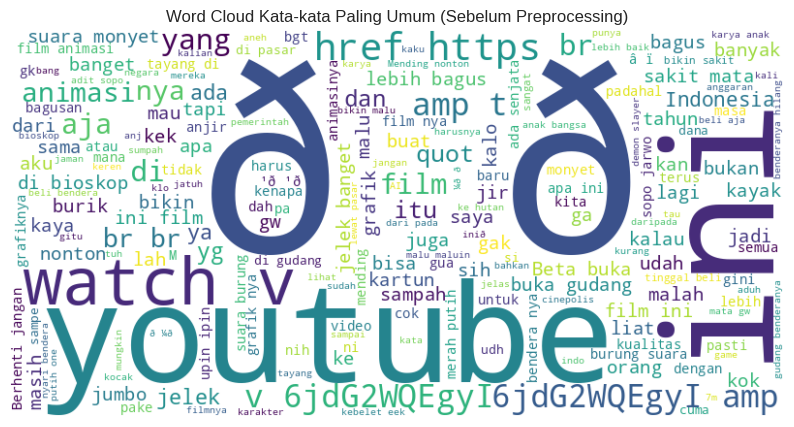


 Ditemukan 126 stopwords dari Sastrawi. Contoh: ['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua']


In [6]:
plt.style.use('seaborn-v0_8-whitegrid')

# Mengidentifikasi kata-kata yang paling sering muncul (sebelum preprocessing)
print("Mengidentifikasi kata-kata paling umum (sebelum preprocessing)...")
all_comments_raw = ' '.join(df['Comment'].dropna())
words_raw = re.findall(r'\b\w+\b', all_comments_raw.lower())
word_counts_raw = Counter(words_raw)
print("\n 10 kata paling umum:", word_counts_raw.most_common(10))

# Visualisasi Word Cloud sebelum preprocessing
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments_raw)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Kata-kata Paling Umum (Sebelum Preprocessing)')
plt.show()

# Mengidentifikasi stopwords dari Sastrawi
stopword_factory = StopWordRemoverFactory()
stopwords = stopword_factory.get_stop_words()
print(f"\n Ditemukan {len(stopwords)} stopwords dari Sastrawi. Contoh: {stopwords[:10]}")

In [7]:
# Regex Cleaning
def clean_text_regex(text):
    # Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Hapus mention dan hashtag
    text = re.sub(r'\@\w+|\#', '', text)
    # Hapus tag <a ...> dan sisakan teks di dalamnya
    text = re.sub(r'<a[^>]*>(.*?)</a>', r'\1', text)
    # Hapus kata "a href" (case-insensitive biar aman)
    text = re.sub(r'a\s*href', '', text, flags=re.IGNORECASE)
    # Hapus <br> (case-insensitive)
    text = re.sub(r'<br\s*/?>', ' ', text, flags=re.IGNORECASE)
    # Hapus emoji
    text = re.sub(r'[\U0001F600-\U0001F64F'
                  r'\U0001F300-\U0001F5FF'
                  r'\U0001F680-\U0001F6FF'
                  r'\U0001F700-\U0001F77F'
                  r'\U0001F780-\U0001F7FF'
                  r'\U0001F800-\U0001F8FF'
                  r'\U0001F900-\U0001F9FF'
                  r'\U0001FA00-\U0001FA6F'
                  r'\U0001FA70-\U0001FAFF'
                  r'\U00002702-\U000027B0'
                  r'\U000024C2-\U0001F251]+', '', text)
    # Hapus karakter non-alfanumerik
    text = re.sub(r'[^\w\s]', '', text)
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    return text

df['clean_text'] = df['Comment'].apply(clean_text_regex)

# Cek hasilnya
df[['Comment', 'clean_text']]

,Comment,clean_text
0,Gak serius bikin film ð malah yang ada biki...,Gak serius bikin film ð malah yang ada bikin k...
1,Lebih bagus ejen ali,Lebih bagus ejen ali
2,jir grafik majapahit aokwaokwaowaokawowawð¤­ð...,jir grafik majapahit aokwaokwaowaokawowawððððð...
3,ini bukan 6&#39;5m malahan 5 ribu rupiah,ini bukan m malahan ribu rupiah
4,Jelek banget grafik nya sama bentuk tokoh nya ...,Jelek banget grafik nya sama bentuk tokoh nya ...
...,...,...
5315,â@@JustAnOrd1naryMankok XXI gaada trailer si...,â XXI gaada trailer sih Gamasuk XXI ya
5316,Kalau fulus<br>Pasti mulus<br>ððð,Kalau fulus Pasti mulus ððð
5317,@@prod.starlight masuk di XXI loh,starlight masuk di XXI loh
5318,Pengisi suara ny spa aj yahhh...,Pengisi suara ny spa aj yahhh


In [8]:
def lowercase_text(text):
    return text.lower()

df['clean_text'] = df['clean_text'].apply(lowercase_text)

# Cek hasilnya
df[['Comment', 'clean_text']]

,Comment,clean_text
0,Gak serius bikin film ð malah yang ada biki...,gak serius bikin film ð malah yang ada bikin k...
1,Lebih bagus ejen ali,lebih bagus ejen ali
2,jir grafik majapahit aokwaokwaowaokawowawð¤­ð...,jir grafik majapahit aokwaokwaowaokawowawððððð...
3,ini bukan 6&#39;5m malahan 5 ribu rupiah,ini bukan m malahan ribu rupiah
4,Jelek banget grafik nya sama bentuk tokoh nya ...,jelek banget grafik nya sama bentuk tokoh nya ...
...,...,...
5315,â@@JustAnOrd1naryMankok XXI gaada trailer si...,â xxi gaada trailer sih gamasuk xxi ya
5316,Kalau fulus<br>Pasti mulus<br>ððð,kalau fulus pasti mulus ððð
5317,@@prod.starlight masuk di XXI loh,starlight masuk di xxi loh
5318,Pengisi suara ny spa aj yahhh...,pengisi suara ny spa aj yahhh


Mengidentifikasi kata-kata paling umum (setelah preprocessing)...

 10 kata paling umum: [('ini', 1006), ('film', 878), ('di', 835), ('ð', 615), ('nya', 613), ('animasi', 517), ('yang', 432), ('ada', 415), ('aja', 369), ('yg', 327)]


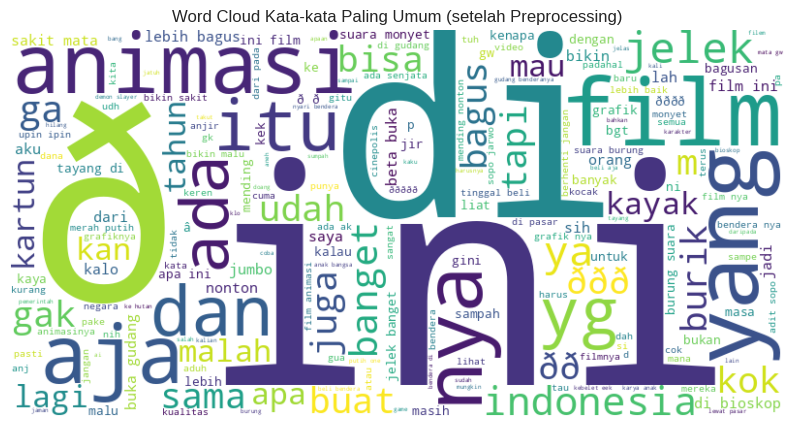

In [9]:
plt.style.use('seaborn-v0_8-whitegrid')

# Mengidentifikasi kata-kata yang paling sering muncul (setelah preprocessing)
print("Mengidentifikasi kata-kata paling umum (setelah preprocessing)...")
all_comments_raw = ' '.join(df['clean_text'].dropna())
words_raw = re.findall(r'\b\w+\b', all_comments_raw.lower())
word_counts_raw = Counter(words_raw)
print("\n 10 kata paling umum:", word_counts_raw.most_common(10))

# Visualisasi Word Cloud setelah preprocessing
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments_raw)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Kata-kata Paling Umum (setelah Preprocessing)')
plt.show()

In [10]:
# Upload file CSV
uploaded = files.upload()

# Ambil nama file pertama yang diupload
file_name = list(uploaded.keys())[0]

kamus_slang = pd.read_csv(file_name, encoding='latin-1', header=None)
kamus_slang.columns = ['slang', 'formal']

# Buat dictionary
slang_dict = dict(zip(kamus_slang['slang'], kamus_slang['formal']))

# Normalisasi slang
def normalize_slang(text):
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

# Terapkan ke dataset
df['clean_text'] = df['clean_text'].apply(normalize_slang)

# Cek hasil
df[['Comment', 'clean_text']]


Saving kamus_slang_formal (1).csv to kamus_slang_formal (1).csv


,Comment,clean_text
0,Gak serius bikin film ð malah yang ada biki...,gak serius bikin film ð bahkan yang ada bikin ...
1,Lebih bagus ejen ali,lebih bagus ejen ali
2,jir grafik majapahit aokwaokwaowaokawowawð¤­ð...,anjing grafik majapahit aokwaokwaowaokawowawðð...
3,ini bukan 6&#39;5m malahan 5 ribu rupiah,ini bukan m malahan ribu rupiah
4,Jelek banget grafik nya sama bentuk tokoh nya ...,jelek banget grafik nya sama bentuk tokoh nya ...
...,...,...
5315,â@@JustAnOrd1naryMankok XXI gaada trailer si...,â xxi tidak ada uang trailer sih gamasuk xxi iya
5316,Kalau fulus<br>Pasti mulus<br>ððð,kalau fulus pasti mulus ððð
5317,@@prod.starlight masuk di XXI loh,starlight masuk di xxi loh
5318,Pengisi suara ny spa aj yahhh...,pengisi suara ny siapa saja yahhh


In [11]:
# Inisialisasi Stemmer Sastrawi - mengubah kata berimbuhan menjadi kata dasar.
# Contoh: “berlari” → “lari”, “makanan” → “makan”.
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

def stemming_text(text):
    return stemmer.stem(text)

df['clean_text'] = df['clean_text'].apply(stemming_text)

# Cek hasilnya
df[['Comment', 'clean_text']]

,Comment,clean_text
0,Gak serius bikin film ð malah yang ada biki...,gak serius bikin film bahkan yang ada bikin ke...
1,Lebih bagus ejen ali,lebih bagus ejen ali
2,jir grafik majapahit aokwaokwaowaokawowawð¤­ð...,anjing grafik majapahit aokwaokwaowaokawowaw
3,ini bukan 6&#39;5m malahan 5 ribu rupiah,ini bukan m malah ribu rupiah
4,Jelek banget grafik nya sama bentuk tokoh nya ...,jelek banget grafik nya sama bentuk tokoh nya ...
...,...,...
5315,â@@JustAnOrd1naryMankok XXI gaada trailer si...,xxi tidak ada uang trailer sih gamasuk xxi iya
5316,Kalau fulus<br>Pasti mulus<br>ððð,kalau fulus pasti mulus
5317,@@prod.starlight masuk di XXI loh,starlight masuk di xxi loh
5318,Pengisi suara ny spa aj yahhh...,isi suara ny siapa saja yahhh


In [12]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google.colab import files
from collections import Counter

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

# Tambahkan stopwords kustom
custom_stopwords = {
    "ini", "di", "dan", "yang", "nya", "ada", "aja", "mau", "yg", "atau", "apapun"
}
stop_words = stop_words.union(custom_stopwords)

# Upload file CSV slang dictionary
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Baca kamus slang
kamus_slang = pd.read_csv(file_name, encoding='latin-1', header=None)
kamus_slang.columns = ['slang', 'formal']
slang_dict = dict(zip(kamus_slang['slang'], kamus_slang['formal']))

# Inisialisasi Stemmer Sastrawi
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

# ==============================
# Tahap Preprocessing
# ==============================
def preprocess_text(text):
    # 1. Cleaning (basic)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)

    # 2. Regex Cleaning tambahan
    text = re.sub(r'<a[^>]*>(.*?)</a>', r'\1', text)
    text = re.sub(r'a\s*href', '', text, flags=re.IGNORECASE)
    text = re.sub(r'<br\s*/?>', ' ', text, flags=re.IGNORECASE)
    text = re.sub(r'[\U0001F600-\U0001F64F'
                  r'\U0001F300-\U0001F5FF'
                  r'\U0001F680-\U0001F6FF'
                  r'\U0001F700-\U0001F77F'
                  r'\U0001F780-\U0001F7FF'
                  r'\U0001F800-\U0001F8FF'
                  r'\U0001F900-\U0001F9FF'
                  r'\U0001FA00-\U0001FA6F'
                  r'\U0001FA70-\U0001FAFF'
                  r'\U00002702-\U000027B0'
                  r'\U000024C2-\U0001F251]+', '', text)  # hapus emoji
    text = re.sub(r'[^\w\s]', '', text)  # hapus karakter non-alfanumerik
    text = re.sub(r'\d+', '', text)      # hapus angka

    # 3. Lowercase
    text = text.lower()

    # 4. Tokenization
    words = text.split()

    # 5. Normalization (slang → formal)
    words = [slang_dict.get(w, w) for w in words]

    # 6. Stopword Removal (default + custom)
    words = [w for w in words if w not in stop_words]

    # 7. Stemming
    words = [stemmer.stem(w) for w in words]

    # 8. Reconstruction
    return " ".join(words)

# Terapkan ke dataset
df['clean_text'] = df['Comment'].astype(str).apply(preprocess_text)

all_words = " ".join(df['clean_text']).split()
word_counts = Counter(all_words)
print("10 kata paling umum:", word_counts.most_common(10))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saving kamus_slang_formal (1).csv to kamus_slang_formal (1) (1).csv
10 kata paling umum: [('film', 937), ('animasi', 580), ('bagus', 452), ('bendera', 409), ('banget', 405), ('jelek', 402), ('suara', 349), ('bikin', 338), ('burung', 301), ('mata', 296)]


### Labeling Data with BERT

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load tokenizer dan model
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Buat pipeline sentiment
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Device set to use cpu


In [14]:
def bert_label(text):
    max_length = tokenizer.model_max_length if hasattr(tokenizer, 'model_max_length') and tokenizer.model_max_length is not None else 512
    truncated_text = text[:max_length]
    result = sentiment_analyzer(truncated_text)[0]  # result = {'label': '5 stars', 'score': 0.85}
    label = result['label']

    # Mapping ke 3 kelas sederhana: 0=negatif, 1=positif, 2=netral
    if label in ['1 star', '2 stars']:
        return 0  # negatif
    elif label == '3 stars':
        return 2  # netral
    else:
        return 1  # positif

df['sentiment_bert'] = df['clean_text'].apply(bert_label)

In [15]:
df[['clean_text', 'sentiment_bert']].head(10)


,clean_text,sentiment_bert
0,gak serius bikin film bikin kecewa,2
1,bagus ejen ali,1
2,anjing grafik majapahit aokwaokwaowaokawowaw,2
3,m ribu rupiah,0
4,jelek banget grafik bentuk tokoh muka yaampun ...,2
5,wanjir sadar pojok,0
6,film hina,1
7,najis deh,2
8,bagus grafik upin ipin,1
9,cuihh najiss,2


### Manual Labeling

In [16]:
import re

# list kata positif & negatif
positive_words = ["bagus", "hebat", "mantap", "luar biasa", "keren", "cepat", "enak", "seru", "lucu", "recommended"]
negative_words = ["jelek", "parah", "buruk", "rusak", "lambat", "mengecewakan", "sakit", "ribet",
                  "sampah", "bangsat", "kecewa", "ngebosenin", "cringe", "hujat", "hina", "najis", "anjir",
                  "deepweb", "grafik", "konyol", "berhenti", "malu", "burik", "buriq", "insto", "sekarat",
                  "monyet", "dosa", "anjing", "koruptor", "cok", "jumbo", "eek", "anying", "jembut",
                  "gaje", "ngakak", "bendera", "edan", "dislike", "aib", "kontol", "wkwk", "rabun",
                  "report", "ajg", "boomer", "ejen"]

def detect_sarcasm(text):
    text = text.lower()

    # cek kata positif & negatif
    pos_found = [w for w in positive_words if w in text]
    neg_found = [w for w in negative_words if w in text]

    # aturan 1️⃣: ada kata positif & negatif dalam satu kalimat
    if pos_found and neg_found:
        return True

    # aturan 2️⃣: pola positif diikuti negatif dalam radius 20 karakter
    pattern = r"(" + "|".join(positive_words) + r").{0,20}(" + "|".join(negative_words) + r")"
    if re.search(pattern, text):
        return True

    # aturan 3️⃣: ada kata penghubung 'tapi' atau 'namun' setelah kata positif
    # contoh: "bagus sih, tapi lambat" → sarkas
    pattern_tapi = r"(" + "|".join(positive_words) + r").{0,15}\b(tapi|namun)\b"
    if re.search(pattern_tapi, text):
        return True

    # aturan 4️⃣: tanda baca berlebihan (!!!, ???)
    if any(p in text for p in ["!!!", "???"]):
        return True

    return False


def auto_label_with_bert_and_sarcasm(text, bert_label_value):
    text = text.lower()

    # cek sarkas dulu
    if detect_sarcasm(text):
        return 0  # override → dianggap NEGATIF

    # cek lexicon positif/negatif
    if any(word in text for word in positive_words):
        return 1  # positif
    elif any(word in text for word in negative_words):
        return 0  # negatif
    else:
        # fallback ke hasil BERT
        return bert_label_value


# contoh penerapan di dataframe
df['sentiment_final'] = df.apply(
    lambda row: auto_label_with_bert_and_sarcasm(row['clean_text'], row['sentiment_bert']),
    axis=1
)

df[['clean_text', 'sentiment_bert', 'sentiment_final']].head(20)


,clean_text,sentiment_bert,sentiment_final
0,gak serius bikin film bikin kecewa,2,0
1,bagus ejen ali,1,0
2,anjing grafik majapahit aokwaokwaowaokawowaw,2,0
3,m ribu rupiah,0,0
4,jelek banget grafik bentuk tokoh muka yaampun ...,2,0
5,wanjir sadar pojok,0,0
6,film hina,1,0
7,najis deh,2,0
8,bagus grafik upin ipin,1,0
9,cuihh najiss,2,0


## TF-IDF

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from collections import Counter

# --- 1️⃣ Gabungan Fitur TF-IDF Word + Character ---
tfidf_word = TfidfVectorizer(analyzer="word", ngram_range=(1, 2), max_features=20000)
tfidf_char = TfidfVectorizer(analyzer="char", ngram_range=(3, 5), max_features=20000)

combined = FeatureUnion([
    ("word", tfidf_word),
    ("char", tfidf_char)
])

X = combined.fit_transform(df["clean_text"])
y = df["sentiment_final"]

print("Distribusi sebelum balancing:", Counter(y))

Distribusi sebelum balancing: Counter({0: 3347, 1: 1276, 2: 697})


In [94]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from collections import Counter

# 1️⃣ Distribusi awal
print("Distribusi sebelum balancing:", Counter(y))

# 2️⃣ Tahap 1: SMOTE untuk kelas 2 (minoritas ekstrem)
smote = SMOTE(sampling_strategy={2: 1200}, random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)
print("Setelah SMOTE untuk kelas 2:", Counter(y_sm))

# 3️⃣ Tahap 2: ROS untuk kelas 1 (kelas menengah)
ros = RandomOverSampler(sampling_strategy={1: 2500}, random_state=42)
X_ros, y_ros = ros.fit_resample(X_sm, y_sm)
print("Setelah ROS untuk kelas 1:", Counter(y_ros))

# 4️⃣ Tahap 3: Sedikit under-sampling kelas 0 (mayoritas)
rus = RandomUnderSampler(sampling_strategy={0: 3000, 1: 2500, 2: 1200}, random_state=42)
X_res, y_res = rus.fit_resample(X_ros, y_ros)
print("Distribusi sesudah Hybrid balancing:", Counter(y_res))

# 5️⃣ Split data setelah balancing
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# 6️⃣ Grid Search untuk SVM
param_grid = {
    'C': [0.1, 1, 5, 10],
    'max_iter': [2000, 3000, 5000]
}

grid = GridSearchCV(
    LinearSVC(class_weight="balanced", random_state=42),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

# 7️⃣ Evaluasi model terbaik
best_svm = grid.best_estimator_
y_pred = best_svm.predict(X_test)

print("\n=== Classification Report (Best Linear SVM) ===")
print(classification_report(y_test, y_pred))


Distribusi sebelum balancing: Counter({0: 3347, 1: 1276, 2: 697})
Setelah SMOTE untuk kelas 2: Counter({0: 3347, 1: 1276, 2: 1200})
Setelah ROS untuk kelas 1: Counter({0: 3347, 1: 2500, 2: 1200})
Distribusi sesudah Hybrid balancing: Counter({0: 3000, 1: 2500, 2: 1200})
Best params: {'C': 1, 'max_iter': 2000}

=== Classification Report (Best Linear SVM) ===
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       600
           1       0.86      0.96      0.90       500
           2       0.91      0.75      0.82       240

    accuracy                           0.89      1340
   macro avg       0.89      0.87      0.88      1340
weighted avg       0.89      0.89      0.89      1340



In [95]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --- Tahap 1: Balancing Manual (RUS + SMOTE) ---
print("Distribusi sebelum balancing:", Counter(y))

# Target distribusi yang diinginkan
target_counts = {
    0: 3347,  # kelas mayoritas tetap
    1: 2000,  # naik ke 2000
    2: 1500   # naik ke 1500
}

# 1️⃣ Undersample kelas mayoritas (0)
rus = RandomUnderSampler(sampling_strategy={0: target_counts[0]}, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)
print("Setelah undersampling:", Counter(y_resampled))

# 2️⃣ Siapkan sampling strategy untuk SMOTE
current_counts = Counter(y_resampled)
sampling_strategy = {}

for label, target in target_counts.items():
    if current_counts[label] < target:
        sampling_strategy[label] = target
    else:
        sampling_strategy[label] = current_counts[label]

# 3️⃣ SMOTE hanya untuk kelas minoritas (1 dan 2)
smote = SMOTE(sampling_strategy={1: target_counts[1], 2: target_counts[2]}, random_state=42)
X_final, y_final = smote.fit_resample(X_resampled, y_resampled)

print("Distribusi sesudah balancing:", Counter(y_final))

# --- Tahap 2: Split Data untuk Training & Testing ---
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

# 6️⃣ Grid Search untuk SVM
param_grid = {
    'C': [0.1, 1, 5, 10],
    'max_iter': [2000, 3000, 5000]
}

grid = GridSearchCV(
    LinearSVC(class_weight="balanced", random_state=42),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

# 7️⃣ Evaluasi model terbaik
best_svm = grid.best_estimator_
y_pred = best_svm.predict(X_test)

print("\n=== Classification Report (Best Linear SVM) ===")
print(classification_report(y_test, y_pred))



Distribusi sebelum balancing: Counter({0: 3347, 1: 1276, 2: 697})
Setelah undersampling: Counter({0: 3347, 1: 1276, 2: 697})
Distribusi sesudah balancing: Counter({0: 3347, 1: 2000, 2: 1500})
Best params: {'C': 10, 'max_iter': 2000}

=== Classification Report (Best Linear SVM) ===
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       670
           1       0.81      0.93      0.87       400
           2       0.92      0.87      0.89       300

    accuracy                           0.90      1370
   macro avg       0.89      0.90      0.89      1370
weighted avg       0.90      0.90      0.90      1370



## SMOTE

In [64]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# Sebelum SMOTE
print("Distribusi sebelum SMOTE:", Counter(y))

# Jalankan SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Sesudah SMOTE
print("Distribusi sesudah SMOTE:", Counter(y_res))


Distribusi sebelum SMOTE: Counter({0: 3347, 1: 1276, 2: 697})
Distribusi sesudah SMOTE: Counter({0: 3347, 2: 3347, 1: 3347})


## Classification with SVM

In [65]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

# --- Split data untuk training dan testing ---
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, stratify=y_final)

# --- Model LinearSVC ---
svm = LinearSVC(class_weight="balanced", random_state=42, max_iter=5000)
svm.fit(X_train, y_train)

# --- Prediksi dan Evaluasi ---
y_pred_svm = svm.predict(X_test)
print("\n=== Classification Report (LinearSVC dengan Hybrid Sampling) ===")
print(classification_report(y_test, y_pred_svm))


=== Classification Report (LinearSVC dengan Hybrid Sampling) ===
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       670
           1       0.81      0.92      0.86       400
           2       0.92      0.86      0.89       300

    accuracy                           0.89      1370
   macro avg       0.89      0.89      0.89      1370
weighted avg       0.90      0.89      0.89      1370



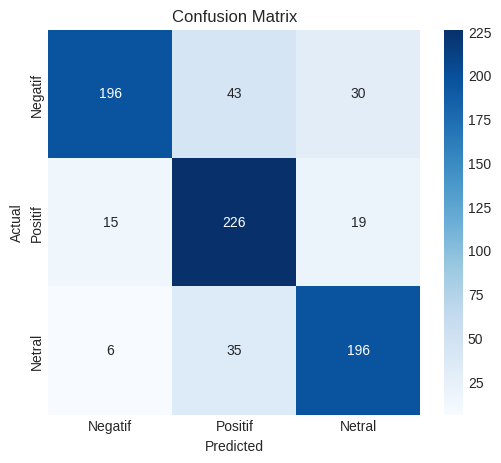

In [42]:
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negatif','Positif','Netral'],
            yticklabels=['Negatif','Positif','Netral'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Classification with Naive Bayes

In [96]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.67      0.94      0.78       670
           1       0.79      0.49      0.61       400
           2       0.94      0.58      0.72       300

    accuracy                           0.73      1370
   macro avg       0.80      0.67      0.70      1370
weighted avg       0.76      0.73      0.72      1370



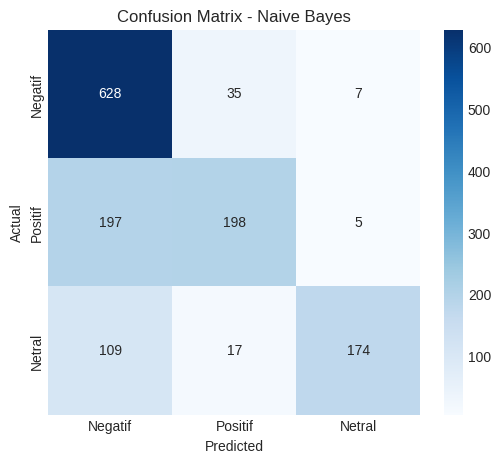

In [67]:
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negatif','Positif','Netral'],
            yticklabels=['Negatif','Positif','Netral'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

## Classification with Decision Tree


In [97]:
clf = DecisionTreeClassifier(
    max_depth=50,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42
)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=50,
                       min_samples_leaf=5, random_state=42)

In [98]:
y_pred_dt = clf.predict(X_test)

print(classification_report(y_test, y_pred_dt, digits=3))




              precision    recall  f1-score   support

           0      0.929     0.746     0.828       670
           1      0.630     0.900     0.742       400
           2      0.770     0.670     0.717       300

    accuracy                          0.774      1370
   macro avg      0.777     0.772     0.762      1370
weighted avg      0.807     0.774     0.778      1370



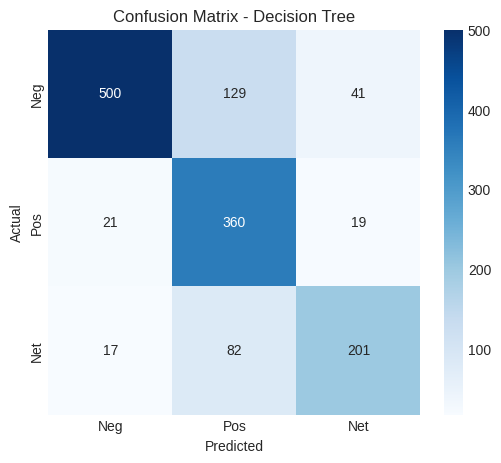

In [70]:
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Neg','Pos','Net'],
            yticklabels=['Neg','Pos','Net'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

## Classification with Random Forest

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, class_weight="balanced_subsample")
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       n_estimators=200, random_state=42)

In [72]:
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82       681
           1       0.76      0.93      0.84       639
           2       0.85      0.89      0.87       689

    accuracy                           0.84      2009
   macro avg       0.86      0.85      0.84      2009
weighted avg       0.86      0.84      0.84      2009

Confusion Matrix:
[[490 119  72]
 [ 12 593  34]
 [  9  68 612]]


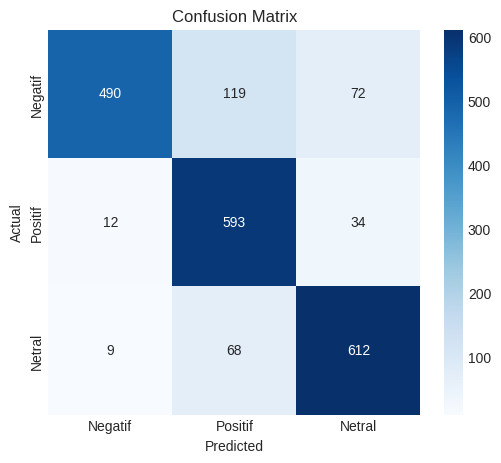

In [73]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negatif','Positif','Netral'],
            yticklabels=['Negatif','Positif','Netral'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Visualization

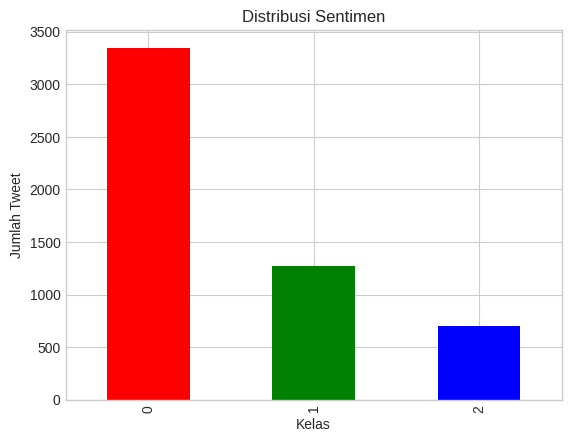

In [74]:
df['sentiment_final'].value_counts().plot(kind='bar', color=['red','green','blue'])
plt.title("Distribusi Sentimen")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Tweet")
plt.show()


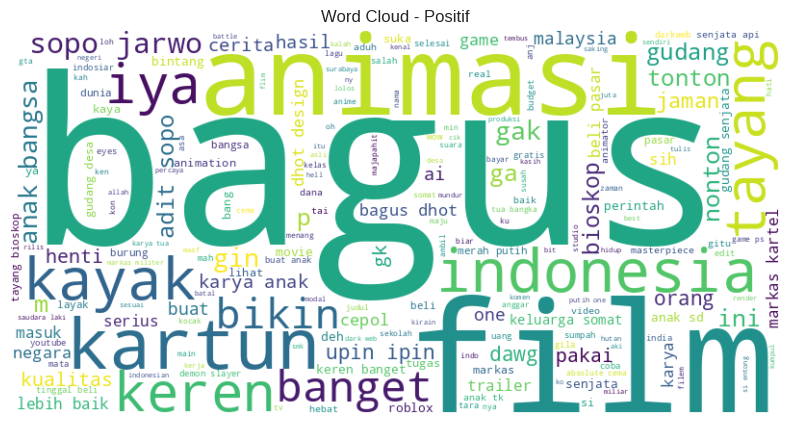

In [75]:
text = " ".join(df[df['sentiment_final']==1]['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Positif")
plt.show()


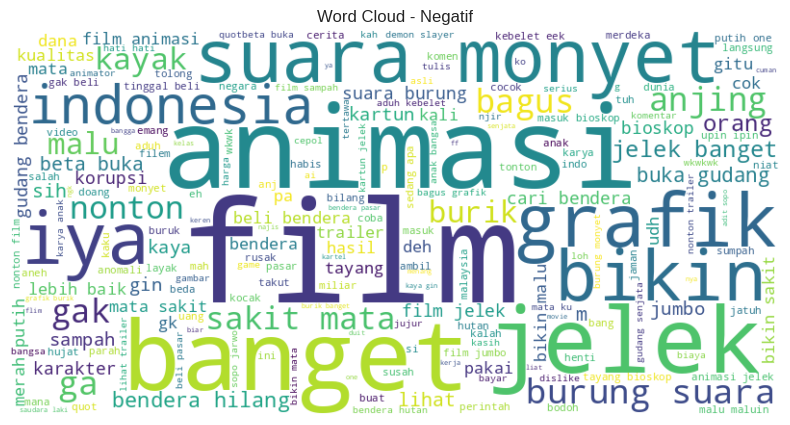

In [76]:
text_neg = " ".join(df[df['sentiment_final']==0]['clean_text'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(text_neg)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Negatif")
plt.show()


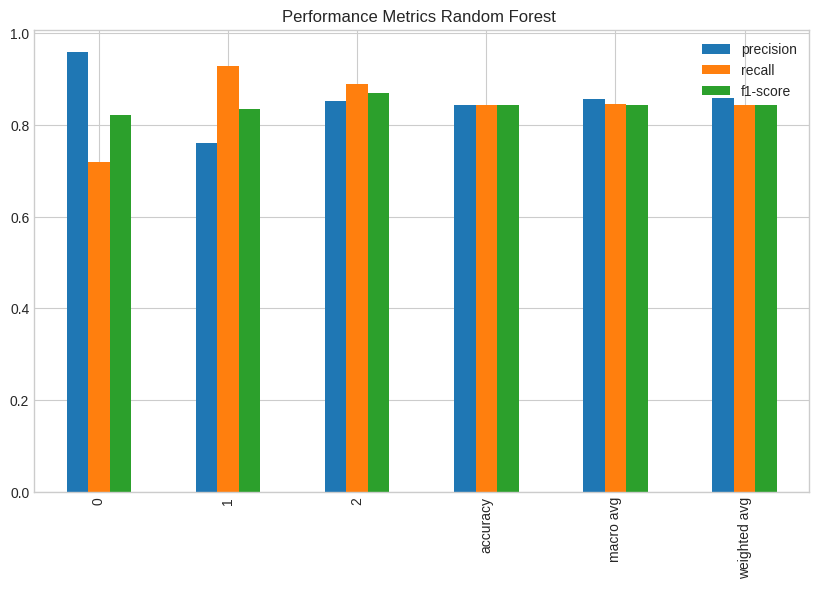

In [77]:
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
report_df[['precision','recall','f1-score']].plot(kind='bar', figsize=(10,6))
plt.title("Performance Metrics Random Forest ")
plt.show()
